# VGG-16 Pre-trained CNN with Imagenet weights

### Import of modules

In [1]:
import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.applications import VGG16, inception_v3, resnet50, mobilenet
from keras import models
from keras import layers
from keras import optimizers, regularizers
from keras.utils import plot_model

Using TensorFlow backend.


### Load data
Unmark the data desired as the input.

In [1]:
#%% Load image path

# Load S2 data
pathway = '/S2/visible_spec/'
name = 'Sentinel-2'

#Load S1 data
#pathway = '/S1/S1_categorical/'
#name = 'Sentinel-1'

## Load Magnetic data
#pathway = '/GEUS/magnetic_category/'
#name = 'Aero Magnetic'

# Load Structural Geology data
#pathway = '/GEUS/structural_geo_category/'
#name = 'Structural geology'

### Defining the file directory for images. This is made for the ease of switching between data input tyoe

In [2]:
#%% Define training and validation directory
train_dir = '/home/kongstad/Master Thesis/filer/data/extracted_patches'+ str(pathway) +'64px_mysplit/train'
validation_dir = '/home/kongstad/Master Thesis/filer/data/extracted_patches'+ str(pathway) +'64px_mysplit/val'

In [3]:
#%% Image size input
image_size = 64

### Load pre-trained model

In [5]:
#%% Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]: #Change -4 to any value to train on more or less layers
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f25db054320> False
<keras.layers.convolutional.Conv2D object at 0x7f25db054860> False
<keras.layers.convolutional.Conv2D object at 0x7f25db0546d8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f25db0745f8> False
<keras.layers.convolutional.Conv2D object at 0x7f25db074c50> False
<keras.layers.convolutional.Conv2D object at 0x7f25da830080> False
<keras.layers.pooling.MaxPooling2D object at 0x7f25da7cb1d0> False
<keras.layers.convolutional.Conv2D object at 0x7f25da7cb828> False
<keras.layers.convolutional.Conv2D object at 0x7f25da7d8710> False
<keras.layers.convolutional.Conv2D object at 0x7f25da77c080> False
<keras.layers.pooling.MaxPooling2D object at 0x7f25da7ab240> False
<keras.layers.convolutional.Conv2D object at 0x7f25da7ab588> False
<keras.layers.convolutional.Conv2D object at 0x7f25da74e470> False
<keras.layers.convolutional.Conv2D object at 0x7f25da75d518> False
<keras.layers.pooling.MaxPooling2D object at 0x7f25da702390>

### The above print indicates that there is no training done on the satellite data but the last 4 layers. The amount of layers can be defined in the code above, see line 5.

### Create model
Loads the VGG model and defines the FC layers.
Several different optimizers can be commented on/off to try different settings.

In [6]:
#%%  Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
#model.add(layers.Dense(2048, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy',
#model.compile(loss='kullback_leibler_divergence',
#              optimizer=optimizers.SGD(lr=0.0002, decay=0.5, momentum=0.8, nesterov=False),
#              optimizer=optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0005),
#              optimizer=optimizers.Adagrad(lr=0.0001, epsilon=None, decay=0.0),
               optimizer=optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
#              optimizer=optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
              
              metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 16,817,989
Trainable params: 9,182,725
Non-trainable params: 7,635,264
_________________________________________________________________


### Setting up data generators and indicating the amount of trainable classes and pictures, as well as amount of validation pictures and corresponding classes

In [8]:
#%% Setting up data generators
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(
      rescale=1./255)


# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 100
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 826 images belonging to 5 classes.
Found 359 images belonging to 5 classes.


### Train the model
Begin model training. Define epochs

In [22]:
#%% Train the model


history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=2)

Epoch 1/100
 - 1s - loss: 1.0333 - acc: 0.5983 - val_loss: 2.1380 - val_acc: 0.2925
Epoch 2/100
 - 1s - loss: 1.0380 - acc: 0.5567 - val_loss: 1.9751 - val_acc: 0.3092
Epoch 3/100
 - 1s - loss: 1.0315 - acc: 0.5914 - val_loss: 2.0417 - val_acc: 0.2786
Epoch 4/100
 - 1s - loss: 1.0256 - acc: 0.6033 - val_loss: 2.0351 - val_acc: 0.3008
Epoch 5/100
 - 1s - loss: 0.9979 - acc: 0.5841 - val_loss: 2.1129 - val_acc: 0.3259
Epoch 6/100
 - 1s - loss: 0.9806 - acc: 0.6020 - val_loss: 1.9754 - val_acc: 0.3315
Epoch 7/100
 - 1s - loss: 0.9744 - acc: 0.5993 - val_loss: 2.1589 - val_acc: 0.3175
Epoch 8/100
 - 1s - loss: 0.9213 - acc: 0.5966 - val_loss: 2.2103 - val_acc: 0.2953
Epoch 9/100
 - 1s - loss: 0.9380 - acc: 0.6168 - val_loss: 2.0126 - val_acc: 0.3008
Epoch 10/100
 - 1s - loss: 0.9131 - acc: 0.6298 - val_loss: 2.2182 - val_acc: 0.2897
Epoch 11/100
 - 1s - loss: 0.9573 - acc: 0.6190 - val_loss: 2.2692 - val_acc: 0.2953
Epoch 12/100
 - 1s - loss: 0.9550 - acc: 0.6206 - val_loss: 2.1429 - val_a

Epoch 98/100
 - 1s - loss: 0.4943 - acc: 0.7771 - val_loss: 3.4550 - val_acc: 0.3092
Epoch 99/100
 - 1s - loss: 0.4676 - acc: 0.7986 - val_loss: 3.5715 - val_acc: 0.3148
Epoch 100/100
 - 1s - loss: 0.4710 - acc: 0.8098 - val_loss: 3.5008 - val_acc: 0.3148


### The following seciton gives the ability to save the model and plot its layout

In [23]:
#%% Save the model
#model.save('savedmodels/vgg_16acc.h5')

#%% Plot the model layout to a png file
#plot_model(model, to_file='convolutional_neural_network.png')

### Evaluate model performance
Check model performance

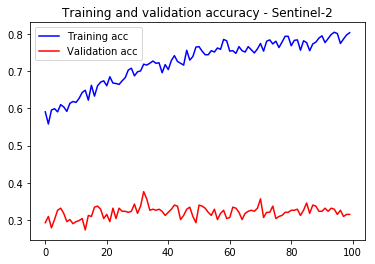

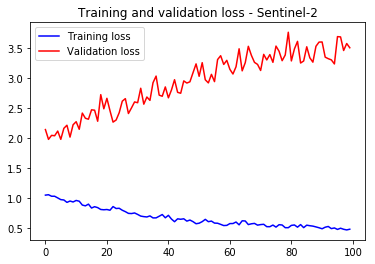

In [24]:
#%% Check performance

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy - ' + str(name))
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss - ' + str(name))
plt.legend()
 
plt.show()

In [25]:
print('Accuracy',"%.2f" % acc[-1])
print('Validation Accuracy', "%.2f" % val_acc[-1])
print('Loss', "%.2f" % loss[-1])
print('Validation loss',"%.2f" % val_loss[-1])

Accuracy 0.80
Validation Accuracy 0.31
Loss 0.48
Validation loss 3.50


In [26]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

correct = np.where(predicted_classes == ground_truth)[0]
print("No of correct = {}/{}".format(len(correct), validation_generator.samples))

Found 359 images belonging to 5 classes.
4/3 [=================================] - 0s 67ms/step
No of errors = 246/359
No of correct = 113/359


### Display prediction with images
First part shows wrong prediction along with image, classificaiton and confidence. Set range in the code to see more or a different set of images.
Second part shows correct predictions

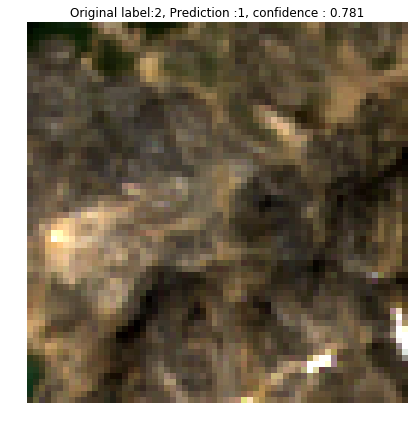

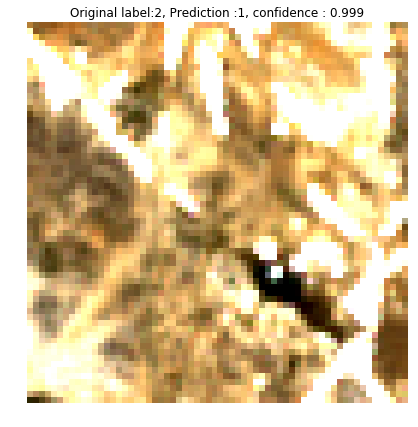

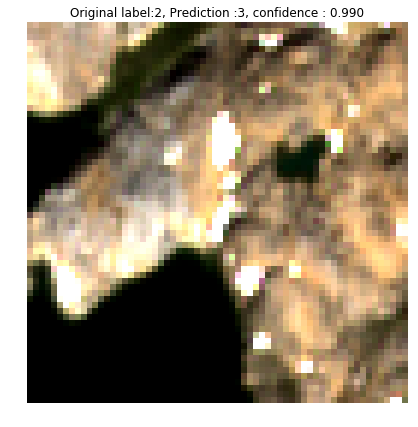

In [69]:
#%% Show the errors

for i in range(100,103):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

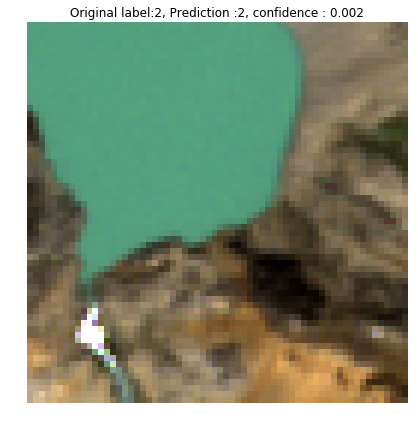

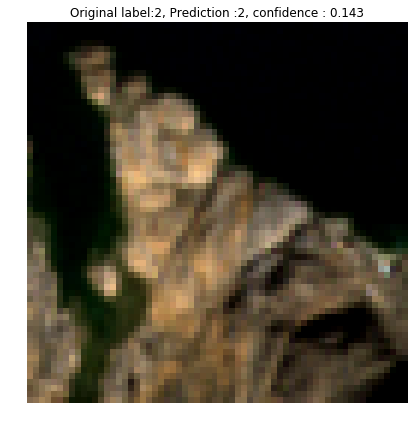

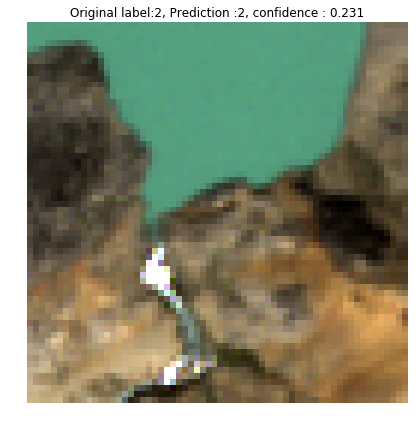

In [74]:
#%% Show the correct
for i in range(40,43):
    pred_class = np.argmax(predictions[correct[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[correct[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = load_img('{}/{}'.format(validation_dir,fnames[correct[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

#### Peter Kongstad - 2019.
#### Master Thesis, Geoscience.